# MNIST на PyTorch

Теперь реализуем ту же задачу, но уже используя удобный фреймворк для обучения моделей под названием PyTorch. С ним написание кода будет намного легче, также это поможет нам использовать видеокарту для обучения.

## Данные

Используем тот же датасет

In [59]:
from sklearn.datasets import fetch_openml
import os
import pandas as pd
import numpy as np

data_path = 'data/mnist'

os.makedirs(data_path, exist_ok=True)

# Загружаем MNIST с OpenML
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home=data_path)
X = X.to_numpy()
y_data = pd.Series(y).to_numpy().astype(int)
y = np.zeros((y_data.shape[0], np.max(y_data)+1))
y[np.arange(y_data.shape[0]), y_data] = 1

Обернём наши данные в класс ```Dataset```, это поможет удобнее работать с данными: разбиение на батчи, разделение на обучение и валидацию. В нашем случае датасет не такой уж и большой и можно загрузить его напрямую.

In [60]:
import torch
from torch.utils.data import Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MNISTDataset(Dataset):
    def __init__(self, data_x, labels):
        super().__init__()
        self.data_x = torch.from_numpy(data_x).float().to(device)
        self.labels = torch.from_numpy(labels).float().to(device)
        
    def __len__(self):
        return self.data_x.shape[0]
    
    def __getitem__(self, index):
        return self.data_x[index], self.labels[index]

Разобьём выборку на обучение и валидацию

In [61]:
from torch.utils.data import random_split, DataLoader
torch.manual_seed(0) #для воспроизводимости

dataset = MNISTDataset(X, y)
train, val = random_split(dataset, [0.8, 0.2])

batch = 32
train_loader = DataLoader(train, batch_size=batch, shuffle=True) #случайные батчи
val_loader = DataLoader(val, batch_size=batch, shuffle=True)

Данные готовы, теперь реализуем нашу модель на PyTorch, только с небольшой поправкой: в pytorch ошибка считается по логитам, то есть по выходам модели до применения softmax. Для инференса можно использовать другую функцию, где уже будет применяться softmax.

## Модель

In [62]:
import torch.nn as nn
from torch.nn import ReLU

class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fcl1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.fcl2 = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.relu = ReLU()
        
    def forward(self, x):
        y = self.fcl1(x)
        y = self.relu(y)
        y = self.fcl2(y)
        return y

## Обучение

In [63]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

input_size = X.shape[1]
hidden_size = 20
output_size = 10

model = Classifier(input_size, hidden_size, output_size).to(device)

optimizer = Adam(params=model.parameters(), lr=3e-4)
criterion = CrossEntropyLoss()

epoch_num = 1

In [64]:
from tqdm import tqdm

train_loss = []
val_loss = []
val_idx = []

val_iter = iter(val_loader)

for epoch in range(epoch_num):
    model.train()
    for i, (inputs, label) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
        if (i+1) % 10 == 0:
            model.eval()
            
            with torch.no_grad():
                try:
                    inputs_val, labels_val = next(val_iter)
                except StopIteration:
                    val_iter = iter(val_loader)
                    inputs_val, labels_val = next(val_iter)
                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)
                val_loss.append(loss_val.item())
                val_idx.append(i+1)

1750it [00:03, 505.54it/s]


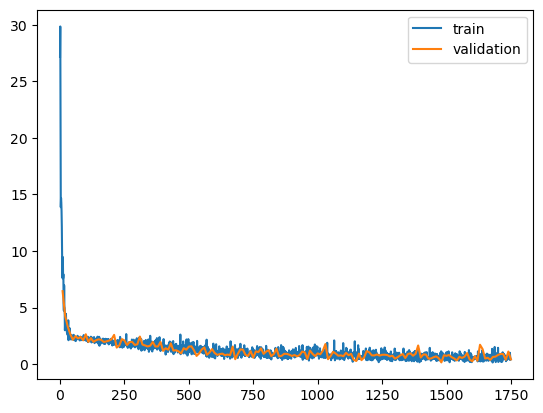

In [65]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(val_idx, val_loss, label='validation')
plt.legend()
plt.show()

Если сравнить с наивной реализацией на NumPy, то удалось достичь более устойчивого обучения (меньше шума), при этом за то же число итераций был достигнут более низкий уровень ошибки. Также по времени обучение произошло гораздо быстрее: три секунды против одной минуты.